# ベイズ回帰

In [149]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 簡単なサンプリング手法

## 逆関数法
生成したい分布関数の逆関数を用いて、一様分布からサンプリングする方法です．

## 棄却法
統計検定1級（理工学2022：問4）の問題を具体例にして，棄却法の説明をします．

### 問題の概要
パラメータが$4,3$であるベータ分布のサンプリングを行いたいという問題です．

ベータ分布は逆関数法からは簡単にはサンプリングできないため，簡単にサンプリング可能な一様分布からの変換を考えます．

このような簡単にサンプリングが行えて，実際にサンプリングをするときに手伝ってくれる分布のことを，教科書では総じて提案分布と呼んでいます．
### ベータ分布の形状
https://max999blog.com/python-beta-distribution-scipy/

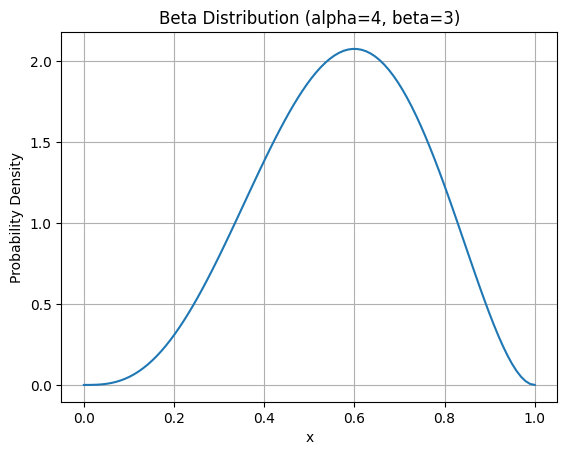

In [150]:
# パラメータ
alpha = 4
beta = 3

# ベータ分布を生成するためのパラメータ
beta_dist = stats.beta(alpha, beta)
ls = np.linspace(0, 1, 100)

# プロット
plt.plot(ls, beta_dist.pdf(ls)) # pdf : Probability density function.
plt.title('Beta Distribution (alpha=4, beta=3)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

独立な一様分布$Y , U$を使って確率変数を次のように定義します．
$$
X = Y \ \ \ (c_0 U \leq f(Y)) \\
\ \ \ -1\ \ \ \ (otherwise)
$$
ただし，$f(Y) = \dfrac{Y^{a-1}(1-Y)^{b-1}}{B(a,b)}$であり，$B(a,b)$はベータ関数です．

また，$c_0$は$f(Y)$の最大値を表します．(問1)

そして，$Pr[(c_0 U \leq f(Y))] = \dfrac{1}{c_0}$ということがわかっています．(問2)

実際に，この確率変数$X$はベータ分布に従うことがわかります．(問3)

### 棄却法のアルゴリズム
1. 提案分布からサンプリングを行う．
2. $c_0 U \leq f(Y)$を満たすかどうかを判定する．
3. 満たさない場合は，1に戻る．
4. 満たす場合は，$X = Y$として，$X$を採用する．
5. 1に戻る．   

1つのサンプルを得るためには，期待値的に$2c_0$個の一様乱数を発生させる必要があります．（問4）

In [151]:
c0 = beta_dist.pdf(0.6)

In [152]:
# お試し実装
u = np.random.uniform(0, 1)
y = np.random.uniform(0, 1)

left = c0 * u
right = beta_dist.pdf(y)

if c0 * u <= beta_dist.pdf(y):
    print(left)
    print(right)
    print('Accept')
else:
    print(left)
    print(right)
    print('Reject')

1.4016594907428166
0.27788588847637413
Reject


In [153]:
# 5回だけ回す
samples = []
for i in range(5):
    u = np.random.uniform(0, 1)
    y = np.random.uniform(0, 1)
    left = c0 * u
    right = beta_dist.pdf(y)
    if c0 * u <= beta_dist.pdf(y):
        samples.append(y)

print(samples)

[0.2907614696974765, 0.629901869753774]


いい感じなので関数を定義して，サンプリングをしてみます．

In [154]:
# 関数として定義
def rejection_sampling(c0 , n_samples=1000):
    samples = []
    for i in range(n_samples):
        u = np.random.uniform(0, 1)
        y = np.random.uniform(0, 1)
        left = c0 * u
        right = beta_dist.pdf(y)
        if c0 * u <= beta_dist.pdf(y):
            samples.append(y)
    return samples

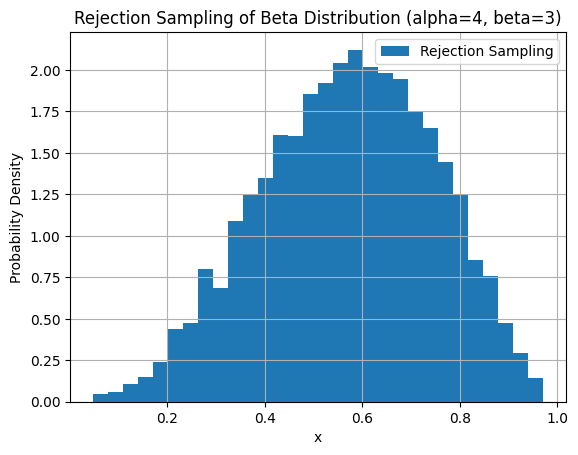

In [155]:
# サンプル数
n_samples = 10000

# 棄却サンプリングの実行
samples = rejection_sampling(c0 , n_samples)

# ヒストグラムのプロット
plt.hist(samples, bins=30, density=True, label='Rejection Sampling')
plt.title('Rejection Sampling of Beta Distribution (alpha=4, beta=3)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

採択される確率は$c_0^{-1}$であったので，確かめてみます．

In [156]:
1/c0 * n_samples

4822.530864197535

In [157]:
len(samples)

4856

## ボックス・マーラー変換
アクチュアリー数学2022問3

正規分布のサンプリング方法

逆関数法で正規分布をサンプリングすることはできません．

しかし，逆関数法で生成できる指数分布と，一様乱数の形状を変化させたものを組み合わせることで，正規分布をサンプリングすることができます．
$$
X = \sqrt{-2 \log U_1} \cos(2 \pi U_2) \\
Y = \sqrt{-2 \log U_1} \sin(2 \pi U_2)
$$

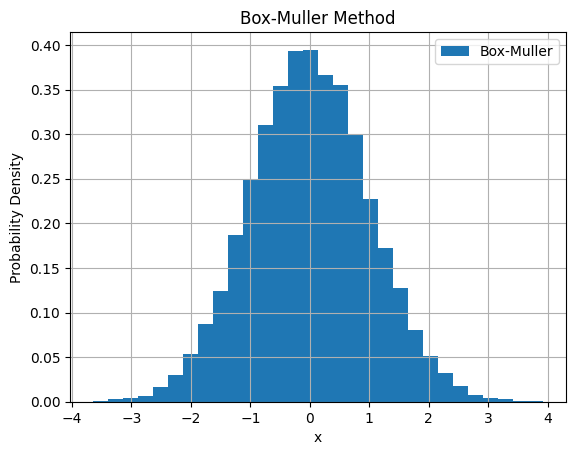

In [158]:
import numpy as np
import matplotlib.pyplot as plt
# ボックス・マーラー法による正規乱数の生成
def box_muller(n_samples=1000):
    samples = []
    for i in range(n_samples):
        u1 = np.random.uniform(0, 1)
        u2 = np.random.uniform(0, 1)
        z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
        z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
        samples.append(z1)
        samples.append(z2)
    return samples

# サンプル数
n_samples = 10000

# ボックス・マーラー法の実行
samples = box_muller(n_samples)

# ヒストグラムのプロット
plt.hist(samples, bins=30, density=True, label='Box-Muller')
plt.title('Box-Muller Method')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

# ベイズ回帰
ビショップ3章を参考に回帰分析を実装します．

## データの生成

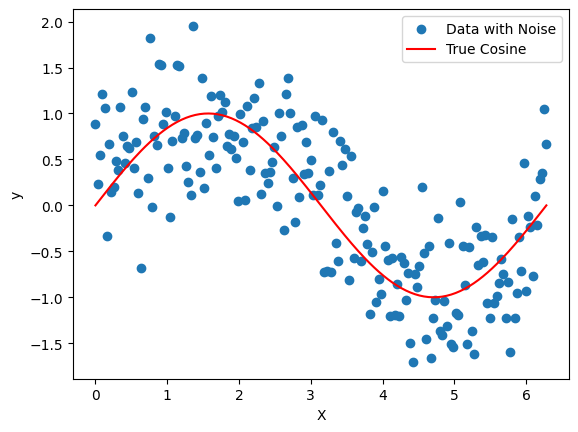

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 乱数のシードを設定
np.random.seed(0)

# データの生成
X = np.linspace(0, 2*np.pi, 200)  # x軸の値（0から2πまでを100等分）
y_true = np.sin(X)                # 真の値（sin関数）
noise = np.random.normal(0, 0.5, 200)  # 正規乱数のノイズ（平均0, 標準偏差0.1）
y = y_true + noise                # 観測値（真の値にノイズを加える）

# データの可視化
plt.scatter(X, y, label='Data with Noise')
plt.plot(X, y_true, color='red', label='True Cosine')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [160]:
# DataFrame型に変換
data = {'X': X, 'y': y}
df = pd.DataFrame(data)
# データシャッフル
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,X,y
0,0.789345,-0.017291
1,6.251612,1.050049
2,4.483479,-0.890578
3,5.114955,-0.445348
4,0.599902,0.137514


In [161]:
# 訓練データのとテストデータに分割
x_train = df['X'].values[:80]
y_train = df['y'].values[:80]
x_test = df['X'].values[80:]
y_test = df['y'].values[80:]

## 回帰分析
様々な基底関数を用いて回帰分析を行います

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html

### モデル化

データセット$\mathcal{D} = \{ (x_n , y_n ) \} _{n = 1,...,N_{train}}$が与えられています．

このデータ間の回帰を以下のような回帰関数でモデル化します．

$\vec{\phi}(x) = (\phi_{0}(x) , \phi_{1}(x) , ... , \phi_{m}(x))^{\top}$ , $\vec{w} = (w_{0} , ... , w_{m})$として

$$
f(x) = \vec{w}^{\top} \vec{\phi}(x)
$$

データセット分を並べた以下のような形になおします．
$$
\vec{f}
=
\begin{pmatrix}
f(x_1) \\
f(x_2)   \\
f(x_3)  \\
・\\
・\\
・\\
f(x_{N_{train}}) \\
\end{pmatrix}
=
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix}
\begin{pmatrix}
w_{0} \\
w_{1}\\
・\\
・\\
・\\
w_{m} \\
\end{pmatrix}
$$

ここで計画行列$\Phi$を以下に定義します．
$$
\Phi = 
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix}
$$


以下のように簡略的に書きましょう．
$$
\vec{f} = \Phi \vec{w}
$$

### 正規方程式（最尤法）
パラメータ$\vec{w}$は最尤法で解きます．その結果はよく知っている正規方程式になり以下のように書けます．
$$
\hat{w} = (\Phi^{\top} \Phi)^{-1} \Phi^{\top} \vec{y}
$$

リッジ回帰（MAP推定）の場合は
$$
\hat{w} = (\Phi^{\top} \Phi + \alpha I)^{-1} \Phi^{\top} \vec{y}
$$

### 予測
最尤法を行った結果，新しいデータ$x^{*}$が与えられたときの予測値$f(x^{*})$を得ることができます．つまり
$$
f(x^*) = \hat{w}^{\top} \phi(x^*)
$$

これが基本的な回帰です．

### 回帰
基底関数を$\phi_{j}(x) = x^{j}$とした場合を考えましょう．

In [162]:
# 基底関数
def phi(x, j):
    return x**j

基底関数を並べて基底関数ベクトルを作ります．
$$
\vec{\phi}(x) = (\phi_{0}(x) , \phi_{1}(x) , ... , \phi_{m}(x))^{\top}
$$

In [163]:
def phi_vector(x, m):
    phi_vector = np.zeros(m)  # m要素の0で初期化された配列を作成
    for i in range(m):
        phi_vector[i] = phi(x, i)
    return phi_vector

計画行列を作ります．
$$
\Phi = 
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix}
$$
これは$N_{train}×(m+1)$行列

In [164]:
# 計画行列
def design_matrix(x_train , m):
    phi = np.zeros((len(x_train) , m))
    for i in range(len(x_train)):
        phi[i] = phi_vector(x_train[i] , m)
    return phi

正常に作動するか見てみましょう

In [165]:
m = 4
d = design_matrix(x_train , m)
print(d)
print(d.shape)

[[1.00000000e+00 7.89344888e-01 6.23065352e-01 4.91813450e-01]
 [1.00000000e+00 6.25161151e+00 3.90826465e+01 2.44329523e+02]
 [1.00000000e+00 4.48347896e+00 2.01015836e+01 9.01250272e+01]
 [1.00000000e+00 5.11495487e+00 2.61627634e+01 1.33821354e+02]
 [1.00000000e+00 5.99902115e-01 3.59882547e-01 2.15894301e-01]
 [1.00000000e+00 2.77849401e+00 7.72002894e+00 2.14500541e+01]
 [1.00000000e+00 5.62013560e+00 3.15859242e+01 1.77517177e+02]
 [1.00000000e+00 8.52492479e-01 7.26743427e-01 6.19543305e-01]
 [1.00000000e+00 9.78787661e-01 9.58025285e-01 9.37703328e-01]
 [1.00000000e+00 4.73606933e+00 2.24303527e+01 1.06231705e+02]
 [1.00000000e+00 3.22052714e+00 1.03717951e+01 3.34026476e+01]
 [1.00000000e+00 2.58905123e+00 6.70318628e+00 1.73548927e+01]
 [1.00000000e+00 2.99951057e+00 8.99706368e+00 2.69867876e+01]
 [1.00000000e+00 1.64183737e+00 2.69562994e+00 4.42578596e+00]
 [1.00000000e+00 6.28318531e+00 3.94784176e+01 2.48050213e+02]
 [1.00000000e+00 6.15689013e+00 3.79072960e+01 2.333910

正規方程式を解きます．

In [166]:
# パラメータの推定
def estimate_parameter(x_train , y_train , m):
    # 計画行列
    phi = design_matrix(x_train , m)
    # パラメータの推定
    w = np.linalg.inv(np.dot(phi.T, phi)).dot(phi.T).dot(y_train)
    return w

In [167]:
m = 4
w = estimate_parameter(x_train , y_train , m)
print(w)

[ 0.03981491  1.46646354 -0.72087117  0.07828516]


テストデータを用いて予測値の計算をしましょう．

In [168]:
# 予測値の計算
def predict(x , w , m):
    phi = phi_vector(x , m)
    y = np.dot(w.T , phi)
    return y

In [169]:
# 予測値の計算
y_pred = np.zeros(len(x_test))
for i in range(len(x_test)):
    y_pred[i] = predict(x_test[i] , w , m)

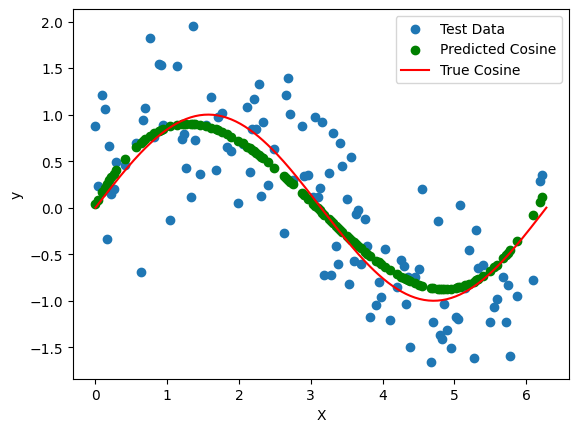

In [171]:
# テストデータの可視化
plt.scatter(x_test, y_test, label='Test Data')
plt.scatter(x_test, y_pred, color='green', label='Predicted Cosine')
plt.plot(X, y_true, color='red', label='True Cosine')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()